In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

df = pd.read_csv(
    "../data/raw/list_11-09-2025.csv",
    sep=";",
    encoding="utf-8-sig",
    engine="python"
)

df = df.copy()

In [3]:
for col in df.select_dtypes(include=["object", "string"]).columns:
    df[col] = df[col].str.strip()
    
df = df.replace(r'^\s*$', np.nan, regex=True)

Очищення текстових значень

Виконується видалення зайвих пробілів і перетворення порожніх рядків у пропущені значення для коректної обробки.

In [4]:
df["sportName"] = df["sportName"].str.title()

Назви видів спорту приводяться до єдиного формату написання для уникнення дублювання категорій під час аналізу.

In [5]:
df["dateAccepted"] = pd.to_datetime(
    df["dateAccepted"],
    dayfirst=True,
    errors="coerce"
)

df["year"] = df["dateAccepted"].dt.year

Поле dateAccepted конвертується у формат datetime, що дозволяє виконувати часовий аналіз.

Із дати затвердження виділяється рік, який буде використано для дослідження динаміки змін.

In [6]:
df = df.dropna(subset=["dateAccepted"])

Видалення нерелевантних записів
Записи без коректної дати виключаються, оскільки вони не можуть використовуватися у часовому аналізі.

In [10]:
df["status"] = df["status"].str.lower()

df["status"] = df["status"].replace({
    "чинний": "active",
    "діючий": "active",
    "нечинний": "inactive",
    "скасований": "inactive"
})

In [9]:
df = df.drop(columns=["publisherIdentifier"], errors="ignore")

In [11]:
print("Після очищення:")
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

df.head()

Після очищення:
Rows: 210
Columns: 10


,identifier,sportName,type,publisherName,title,dateAccepted,number,status,url,year
0,2025-33/4.1/25,Бочча,"З грифом ""Затверджено""",Міністерство молоді та спорту України,Правила спортивних змагань з бочча серед осіб ...,2025-09-11,33/4.1/25,active,https://mms.gov.ua/storage/app/sites/16/Sport/...,2025.0
1,2025-32/3.5/25,Регбі,"З грифом ""Затверджено""",Міністерство молоді та спорту України,Правила спортивних змагань з регбі,2025-08-21,32/3.5/25,active,https://mms.gov.ua/storage/app/sites/16/Sport/...,2025.0
2,2025-31/4.1/25,Легка Атлетика,"З грифом ""Затверджено""",Міністерство молоді та спорту України,Правила спортивних змагань з пара легкої атлет...,2025-08-13,31/4.1/25,active,https://mms.gov.ua/storage/app/sites/16/Sport/...,2025.0
3,2025-30/3.2/25,Кікбоксинг Wако,"З грифом ""Затверджено""",Міністерство молоді та спорту України,Правила спортивних змагань з кікбоксингу WAKO,2025-08-08,30/3.2/25,active,https://mms.gov.ua/storage/app/sites/16/Sport/...,2025.0
4,2025-29/3.2/25,Комбат Самозахист Ісо,"З грифом ""Затверджено""",Міністерство молоді та спорту України,Правила спортивних змагань з комбат самозахист...,2025-08-08,29/3.2/25,active,https://mms.gov.ua/storage/app/sites/16/Sport/...,2025.0


Гіпотеза 1. Популярність виду спорту

Передбачається, що більш поширені види спорту мають більшу кількість затверджених правил змагань та частіше оновлюються.

In [12]:
sport_counts = (
    df["sportName"]
    .value_counts()
    .sort_values(ascending=False)
)

sport_counts.head(15)

sportName
Грепплінг                          5
Пауерліфтинг                       4
Таеквон-До                         4
Веслування На Байдарках І Каное    4
Панкратіон                         4
Армрестлінг                        4
Парашутний Спорт                   4
Комбат Самозахист Ісо              3
Комбат Дзю-Дзюцу                   3
Таїландський Бокс Муей Тай         3
Боротьба Самбо                     3
Альпінізм                          3
Гирьовий Спорт                     3
Бадмінтон                          3
Джиу-Джитсу                        3
Name: count, dtype: int64

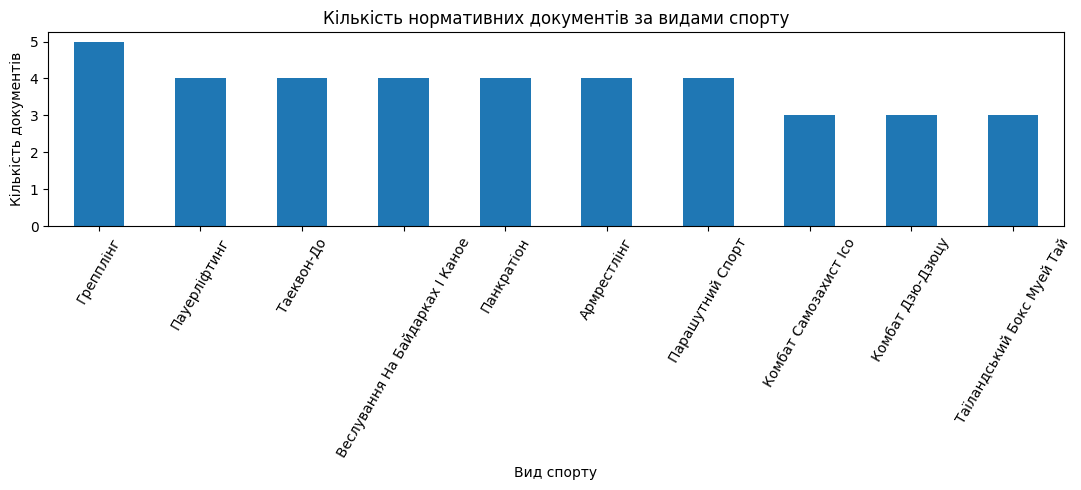

In [13]:
import matplotlib.pyplot as plt

top10 = sport_counts.head(10)

plt.figure(figsize=(11,5))
top10.plot(kind="bar")
plt.title("Кількість нормативних документів за видами спорту")
plt.xlabel("Вид спорту")
plt.ylabel("Кількість документів")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

Підрахунок кількості документів показав, що розподіл є відносно рівномірним: більшість видів спорту мають 3–4 затверджені правила змагань. Найбільшу кількість документів має греплінг (5), тоді як інші види спорту (пауерліфтинг, тхеквондо, панкратіон, армрестлінг, парашутний спорт тощо) мають по 3–4 документи.

Це свідчить, що кількість нормативних актів не концентрується лише на окремих «найпопулярніших» видах спорту, а розподілена між різними дисциплінами досить рівномірно. Попередньо можна зробити висновок, що сама по собі кількість документів не є прямим індикатором популярності виду спорту.

Гіпотеза 2. Динаміка затвердження

Передбачається, що у новіші роки кількість затверджених правил є більшою, ніж у попередні періоди.

In [14]:
year_counts = (
    df["year"]
    .value_counts()
    .sort_index()
)

year_counts

year
2013.0    10
2014.0     4
2015.0     3
2017.0     3
2018.0    11
2019.0    19
2020.0     5
2021.0    40
2022.0    11
2023.0    16
2024.0    55
2025.0    33
Name: count, dtype: int64

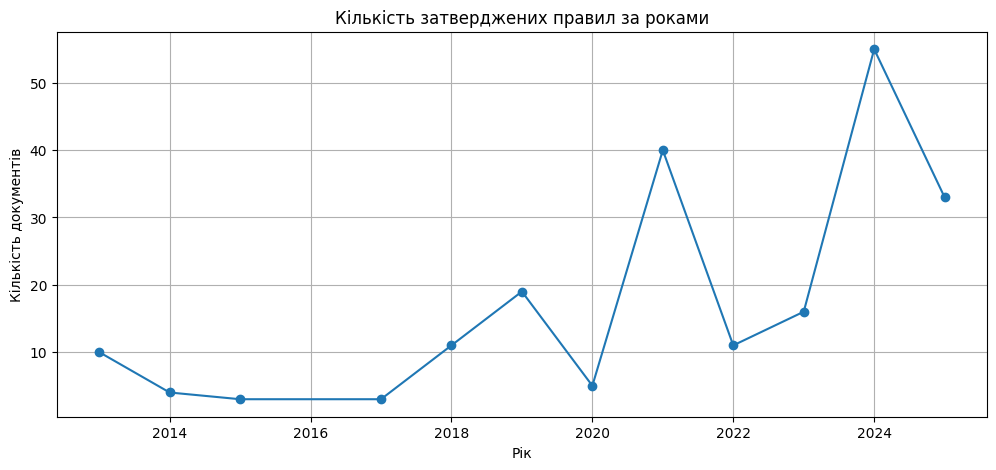

In [15]:
plt.figure(figsize=(12,5))
year_counts.plot(kind="line", marker="o")
plt.title("Кількість затверджених правил за роками")
plt.xlabel("Рік")
plt.ylabel("Кількість документів")
plt.grid(True)
plt.show()

Аналіз розподілу документів за роками показав нерівномірну динаміку їх затвердження. У період 2013–2017 років кількість нових правил була відносно низькою (3–10 документів на рік). Починаючи з 2018 року спостерігається зростання активності, а після 2021 року — різке збільшення кількості затверджених правил.

Найбільш активним є 2024 рік (55 документів), також високі значення зафіксовано у 2021 (40) та 2025 (33) роках. Це свідчить про суттєве оновлення нормативної бази у новіші роки.

Отже, гіпотеза підтверджується: у сучасний період кількість затверджених правил змагань значно більша, ніж у попередні роки, що може бути пов’язано з реформуванням спортивного регулювання та переглядом нормативних документів.

Гіпотеза 3. Актуальність документів

Передбачається, що нормативні документи переглядаються або втрачають чинність через кілька років після затвердження.

In [16]:
status_counts = df["status"].value_counts()
status_counts

status
active              151
втратив чинність     52
зі змінами            7
Name: count, dtype: int64

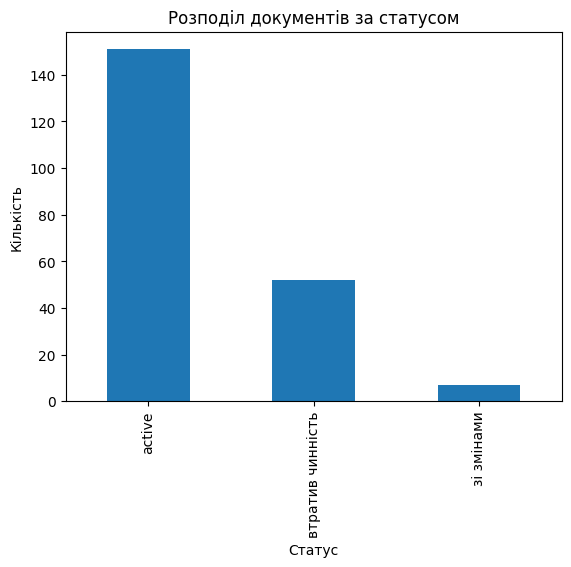

In [17]:
status_counts.plot(kind="bar")
plt.title("Розподіл документів за статусом")
plt.xlabel("Статус")
plt.ylabel("Кількість")
plt.show()

In [20]:
today = pd.Timestamp.today()

df["age_years"] = (today - df["dateAccepted"]).dt.days / 365
df["age_years"].describe()

count    210.000000
mean       4.045519
std        3.246234
min        0.443836
25%        1.336301
50%        3.350685
75%        5.444521
max       12.898630
Name: age_years, dtype: float64

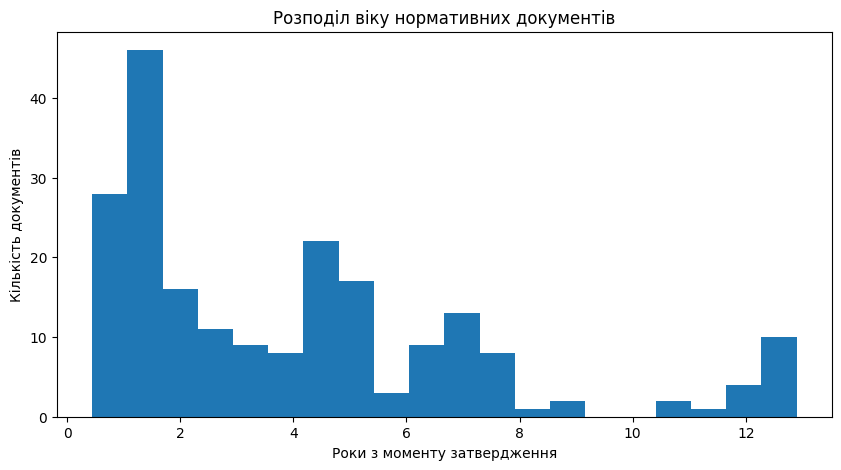

In [22]:
plt.figure(figsize=(10,5))
plt.hist(df["age_years"], bins=20)
plt.title("Розподіл віку нормативних документів")
plt.xlabel("Роки з моменту затвердження")
plt.ylabel("Кількість документів")
plt.show()

Розподіл документів за статусом показує, що більшість правил є чинними (151 документ). Водночас значна кількість документів втратила чинність (52), а невелика частина має статус змінених (7). Це свідчить про регулярний перегляд нормативної бази та поступову заміну застарілих правил новими редакціями.

Аналіз віку документів показав, що середній строк дії правил становить приблизно 4 роки. Більшість документів існує в інтервалі 1–6 років з моменту затвердження, після чого вони часто оновлюються або втрачають чинність. Окремі документи залишаються чинними понад 10 років, однак це поодинокі випадки.

Отже, гіпотеза підтверджується: нормативні документи у сфері спорту регулярно переглядаються, а значна їх частина оновлюється протягом кількох років після прийняття.